In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torchvision
import torch
from torch import nn

%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path

import pickle
from sklearn.model_selection import train_test_split
from scipy.special import softmax

In [2]:
b = 4
t = 11
first_blow = 6
embd_size = 13

softer = nn.Sequential(
    nn.Conv1d(1, first_blow, kernel_size=1, stride=1),
    nn.LeakyReLU(inplace=True),
    nn.Conv1d(first_blow, embd_size, kernel_size=1, stride=1, bias=False),
)

idx = torch.rand(b, t)  # 4 x 1023

In [54]:
nn.Softmax(dim=0)(np.zeros(8))

AttributeError: 'numpy.ndarray' object has no attribute 'softmax'

In [132]:
def normal(mu, sigma):
    def _f(x):
          return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return _f

  
def soft_quant(classes, sigma, norm=nn.Softmax(dim=0), trans=True):
    basis = torch.linspace(0, classes - 1, classes)
        
    def _f(x):
        N = normal(x, sigma)
        vector = torch.stack([
            N(b) for b in basis
        ], dim=0)
        
        if norm:
            vector = norm(vector)
        
        if trans:
            vector = torch.transpose(vector, 0, 1)

        return vector
    return _f


def apply_batchwise(func, M):
    tList = [ func(m) for m in torch.unbind(M, dim=0) ]  # batch is first index
    return torch.stack(tList, dim=0)


def soft_torch(**kwargs):
    s = soft_quant(**kwargs)

    def _f(x):  # x ~ batch x elements
        return apply_batchwise(s, x)

    return _f


# soft_quant(classes=n_soft_classes, sigma=10)(idx[0]).shape
te = soft_torch(classes=32, sigma=0.5, trans=False)(idx)
print(te.shape)
gc(te).shape

torch.Size([4, 32, 11])


torch.Size([4, 256, 11])

In [7]:
gc = nn.Conv1d(32, 256, kernel_size=1, stride=1, bias=False)

In [3]:
def get_figsize(n_rows, n_cols):
    row_size = 8  # heigth
    column_size = 20  # width

    return (n_cols * column_size, n_rows * row_size)


def get_figa(n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=get_figsize(n_rows, n_cols))
    return fig, ax

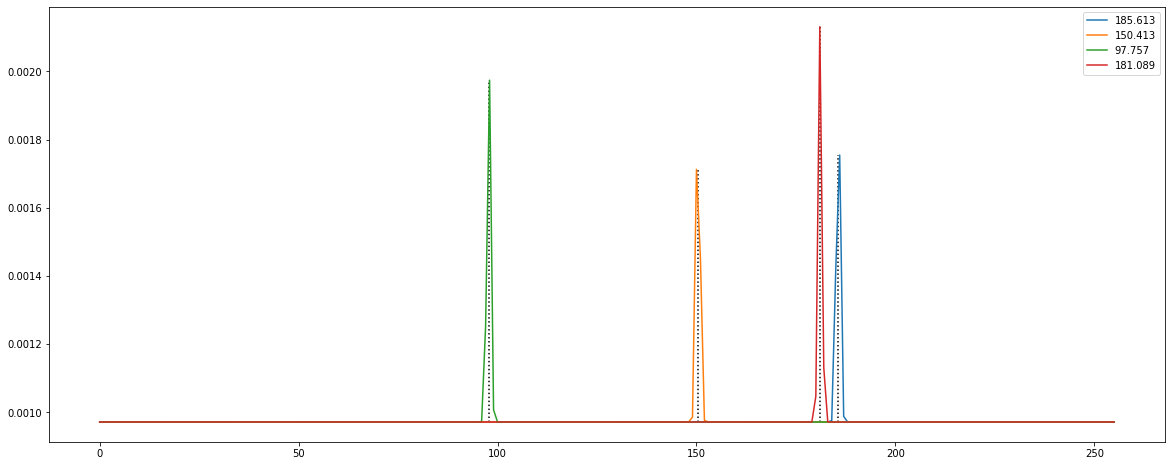

In [127]:
n_soft_classes = 256


def normal(mu, sigma):
    def _f(x):
      return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return _f

  
def soft_quant(classes, sigma, norm=None):
    def _f(x):
        N = normal(x, sigma)
        vector = [
            N(b)
            for b in range(classes)
        ]
        
        if norm:
            return norm(vector)
        
        return vector
    return _f
  

s = soft_quant(n_soft_classes, sigma=0.5, norm=softmax)
basis = list(range(n_soft_classes))

fig, axis = get_figa(1, 1)
batch = np.random.uniform(0, n_soft_classes, size=4)
representation = s(batch).T  # 4 x 256

for x, r in zip(batch, representation):    
    axis.plot(basis, r, label='{:.3f}'.format(x))
    axis.vlines(x=x, ymin=min(r), ymax=max(r), color='black', linestyle='dotted')
    
axis.legend()

In [5]:
softmax([0.5, 0.2])

array([0.57444252, 0.42555748])